In [106]:
import os, sys, json
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

from collections import defaultdict
from tabulate import tabulate
import numpy as np
import scipy.stats

import matplotlib.pyplot as plt

plt.style.use('ggplot')

model_names = ["wgan", "wgpgan", "nsgan", "mmgan", "ragan", 
               "lsgan", "dragan", "began", "infogan", "fishergan", 
               "fgan_forward_kl", "fgan_reverse_kl", "fgan_jensen_shannon",
               "fgan_total_var", "fgan_hellinger", "fgan_pearson"]
distance_metrics=["KL-Divergence", "Jensen-Shannon", "Wasserstein-Distance", "Energy-Distance"]
distributions=['normal', 'beta', 'gumbel', 'laplace', 'exponential', 'gamma']

palette = ["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", "#98df8a", "#d62728", "#ff9896", "#9467bd",
            "#c5b0d5", "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", "#c7c7c7", "#bcbd22" "#dbdb8d",
            "#17becf", "#9edae5"]


def get_confidence_intervals_multivariate(mypath):

    # Get file path and files therein
    files = os.listdir(mypath)
    results = []

    # Load files
    for file in files:

        if file == '.DS_Store':
            continue

        with open("{}/{}".format(mypath, file)) as f:
            data = json.load(f)
        
        results.append(data)
        
    # Get values for best runs
    optimal = nested_pickle_dict()
    for result in results:
        for model, distributions in result.items():
            for distribution, metrics in distributions.items():
                for metric, values in metrics.items():
                    if metric not in optimal[model][distribution]:
                        optimal[model][distribution][metric] = {'values': [], "parameters": []}
                    
                    if metric not in ['DLoss', 'GLoss', "LR", "HDIM", "BSIZE"]:
                        optimal[model][distribution][metric]['values'].append(values['value'])
                        optimal[model][distribution][metric]["parameters"].append(values["parameters"])

    # Compute 5th and 95th percentiles for each epoch
    for result in results:
        for model, distributions in result.items():
            for distribution, metrics in distributions.items():
                for metric, values in metrics.items():
                    if metric not in ['DLoss', 'GLoss']:
                        data = np.column_stack(optimal[model][distribution][metric]['values'])
                        mean, h, low, high = mean_confidence_interval(data)
                        optimal[model][distribution][metric]['low'] = list(low)
                        optimal[model][distribution][metric]['h'] = h
                        optimal[model][distribution][metric]['mean'] = list(mean)
                        optimal[model][distribution][metric]['high'] = list(high)
                    
                        
    return optimal


def get_confidence_intervals_mnist(*args):
    """ Compute 95% confidence intervals for MNIST """
    return get_confidence_intervals_multivariate(*args)


def graph_mnist(optimal, distance_metrics=["KL-Divergence", "Jensen-Shannon", "Wasserstein-Distance", "Energy-Distance"]):
    
    for dist in distance_metrics:

        for model_name in optimal.keys():

            if model_name in ['vae', 'autoencoder']:
                continue
                
            if len(optimal[model_name]['mnist'][dist]['mean']) == 0:
                pass
            else:
                
                plt.plot(range(len(optimal[model_name]['mnist'][dist]['mean'])), 
                         optimal[model_name]['mnist'][dist]['mean'], 
                         label=model_name)

                plt.xlabel("Epoch")
                plt.ylabel(dist)
                plt.title("{0}".format(dist))
                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        #     plt.savefig('graphs/mnist/{1}.png'.format(dist), dpi=100)
        plt.show()
        
        
def graph_multivariate(optimal, 
                       model_names=model_names,
                       distance_metrics=distance_metrics,
                       distributions=distributions,
                       palette=palette):
    
    for metric in distance_metrics:

        for distribution in distributions:

            for idx, model_name in enumerate(model_names):

                if model_name in ['vae', 'autoencoder']:
                    continue

                plt.plot(range(len(optimal[model_name][distribution][metric]['mean'])), 
                             optimal[model_name][distribution][metric]['mean'], 
                             label=model_name,
                             c=palette[idx])

                plt.xlabel("Epoch")
                plt.title("{0}: {1}".format(metric, distribution))
                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        #     plt.savefig('graphs/mnist/{1}.png'.format(dist), dpi=100)
            plt.show()
    
            
def mean_confidence_interval(data, axis=1, confidence=0.95):
    try:
        n = data.shape[axis]
    except IndexError:
        axis = 0
        n = data.shape[axis]
    
    mu, std = np.mean(data, axis=axis), scipy.stats.sem(data, axis=axis)
    h = std * scipy.stats.t.ppf((1 + confidence) / 2., n-1)        
    
    return mu, h, mu-h, mu+h


def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


def nested_pickle_dict():
    """ Picklable defaultdict nested dictionaries """
    return defaultdict(nested_pickle_dict)

In [2]:
# optimal_1000 = get_confidence_intervals_multivariate("/Users/sob/Desktop/gan_results/best/multivariate/16_dims_1000_samples/")
# optimal_10000 = get_confidence_intervals_multivariate("/Users/sob/Desktop/gan_results/best/multivariate/16_dims_10000_samples/")
# optimal_100000 = get_confidence_intervals_multivariate("/Users/sob/Desktop/gan_results/best/multivariate/16_dims_100000_samples/")

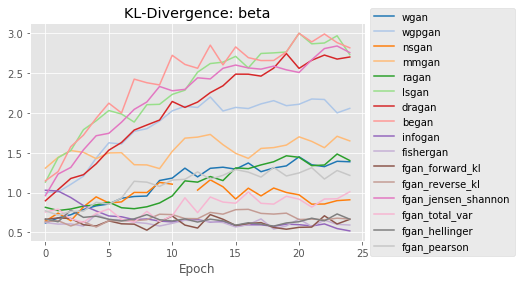

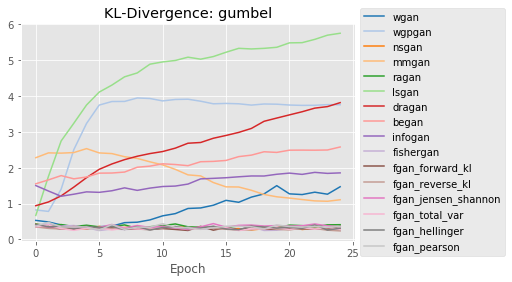

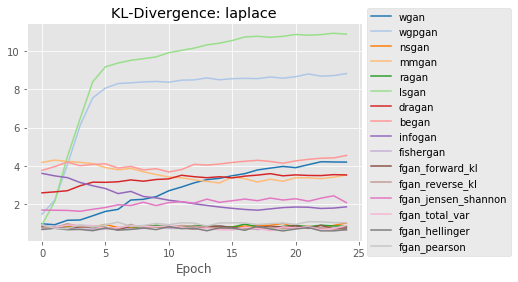

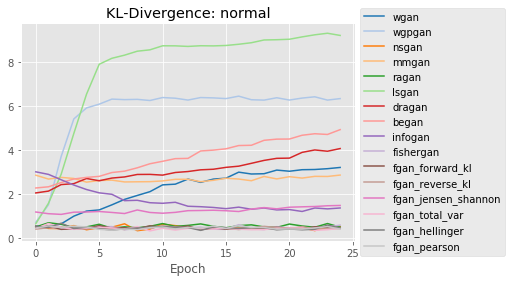

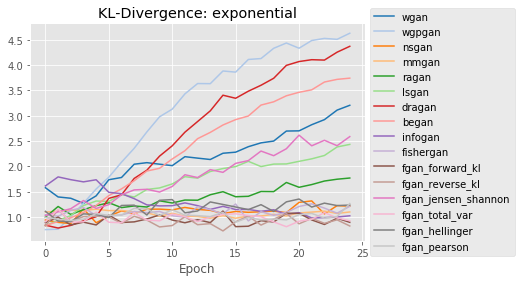

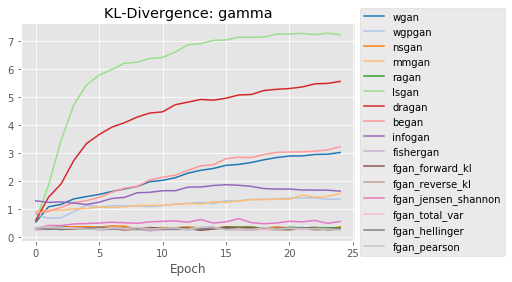

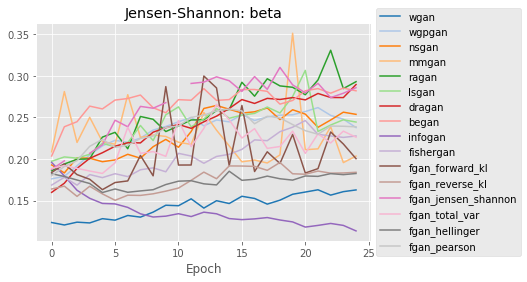

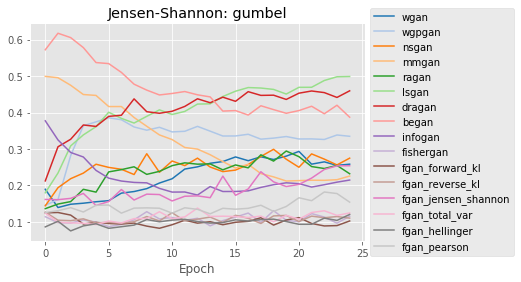

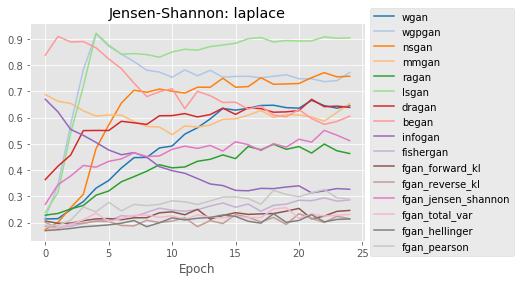

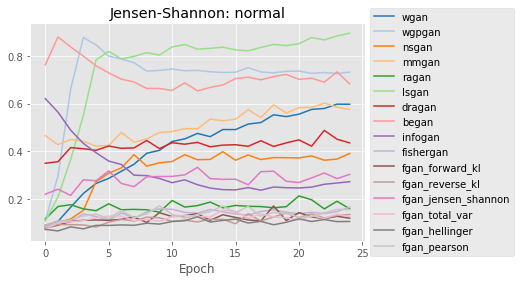

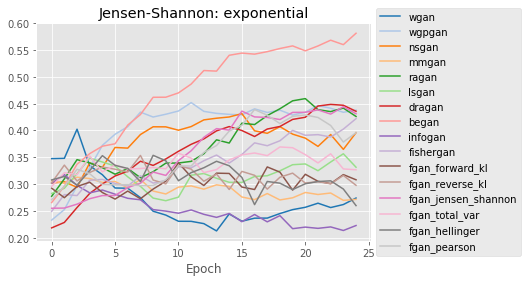

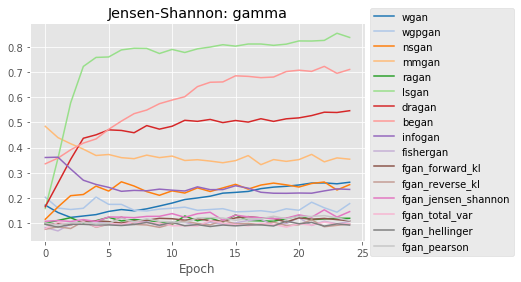

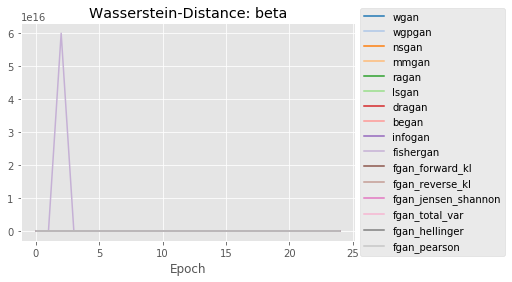

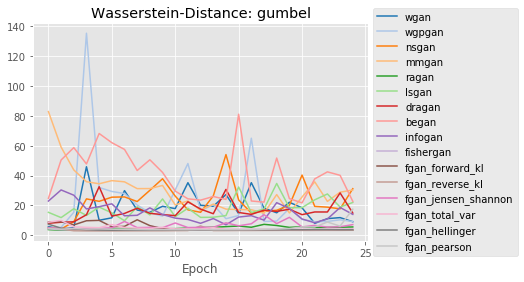

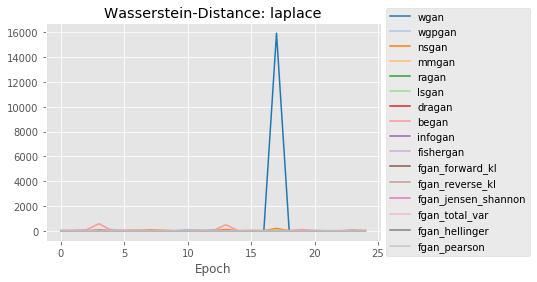

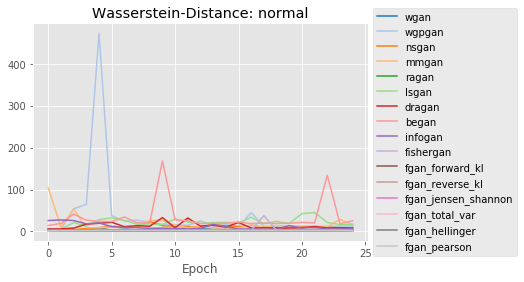

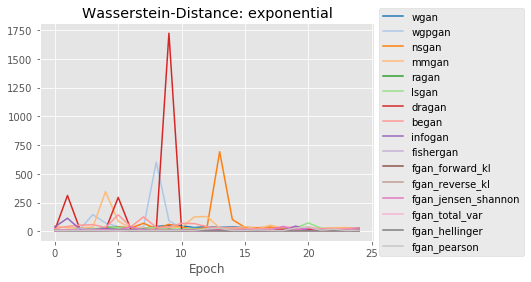

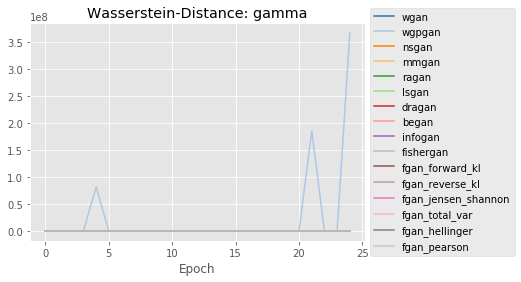

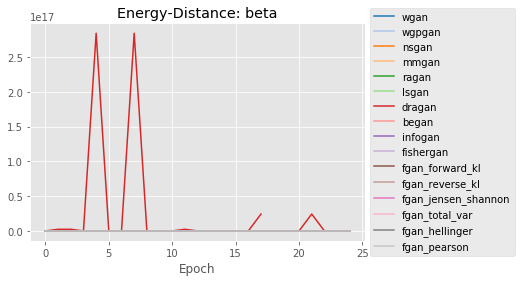

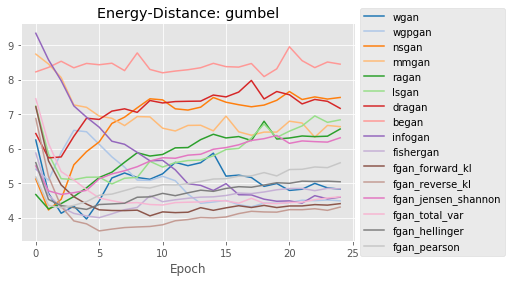

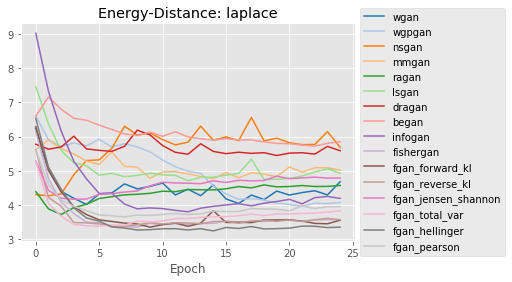

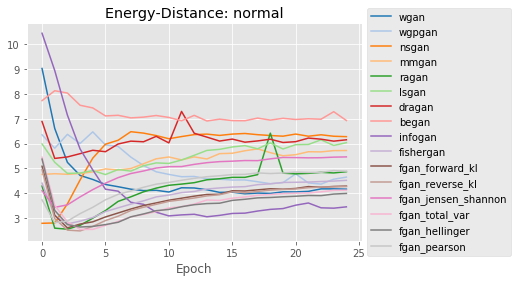

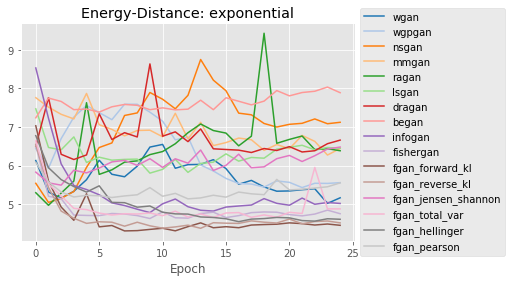

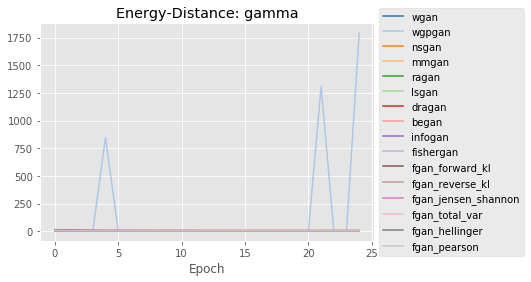

In [24]:
graph_multivariate(optimal_1000)

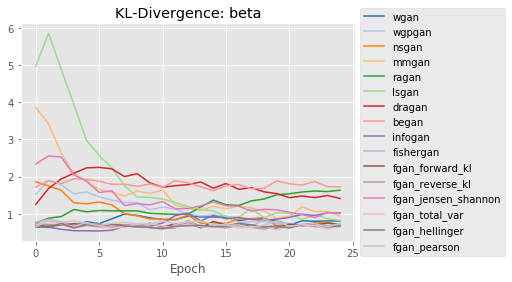

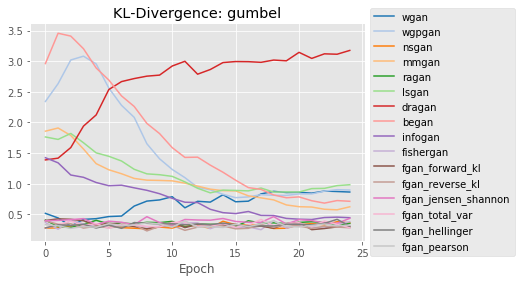

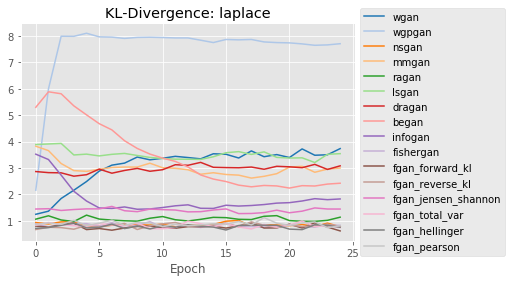

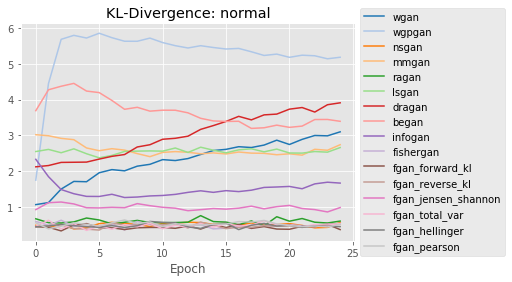

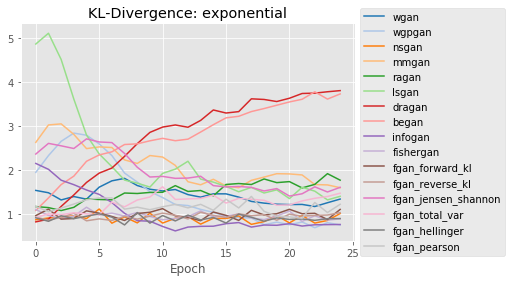

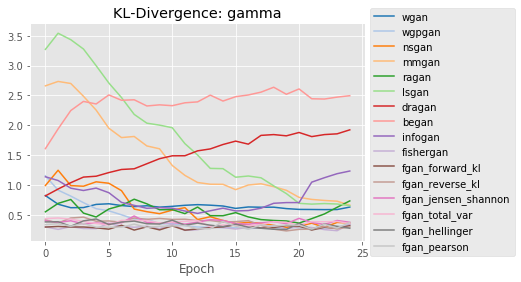

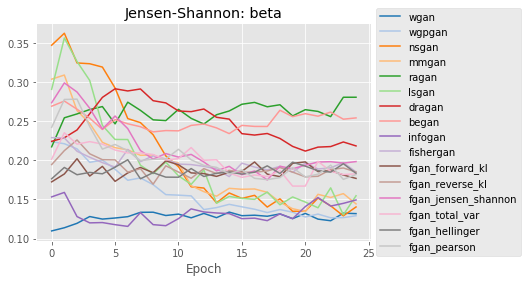

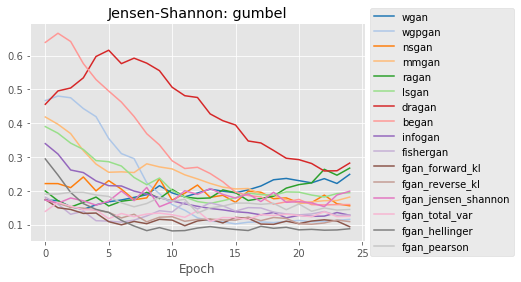

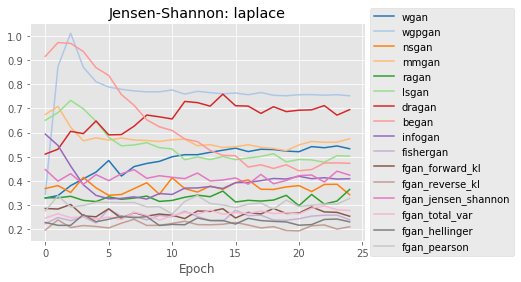

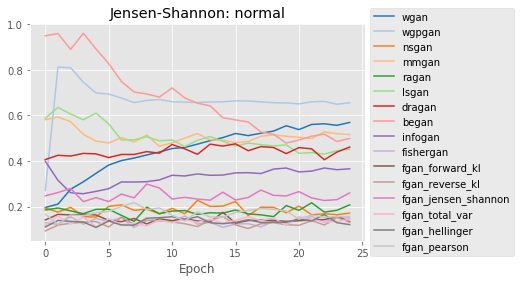

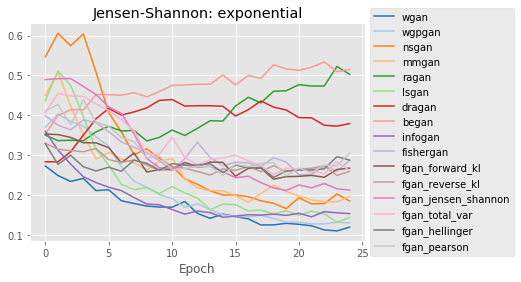

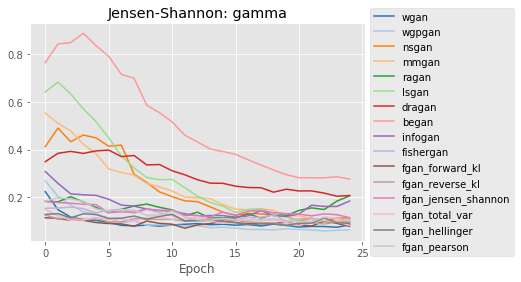

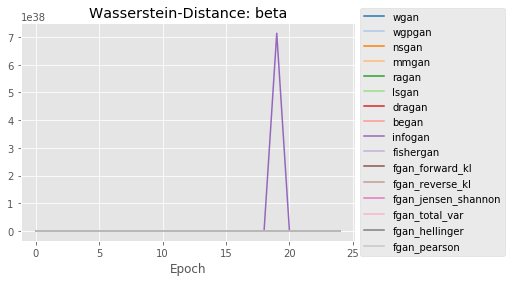

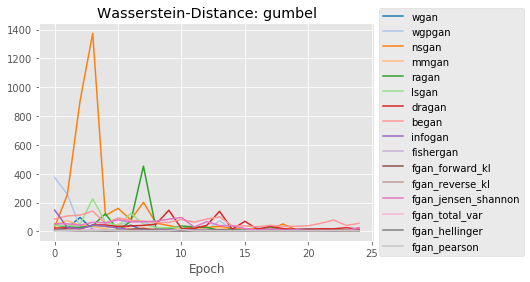

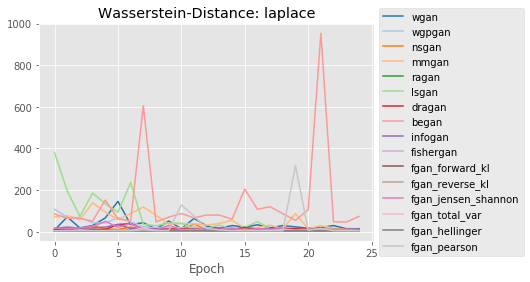

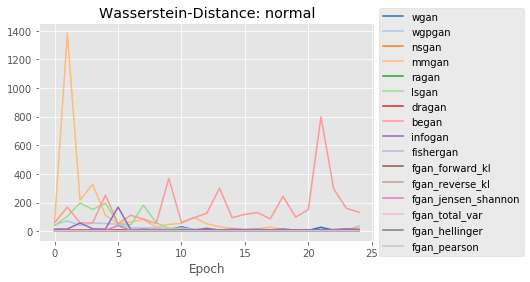

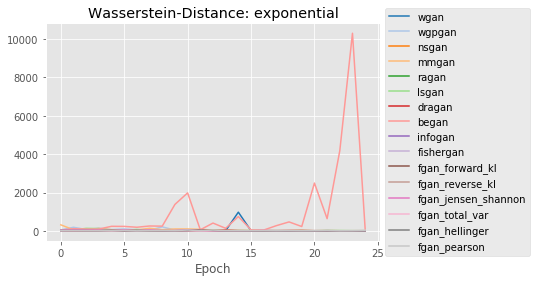

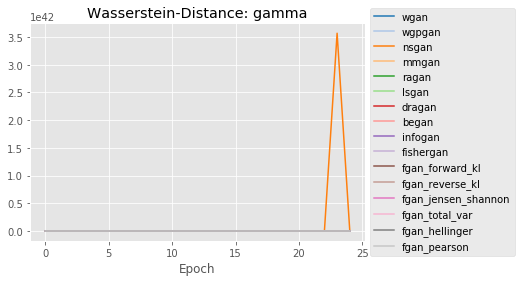

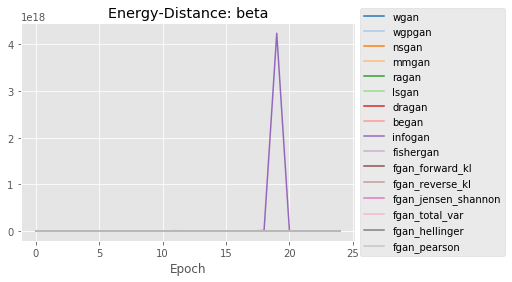

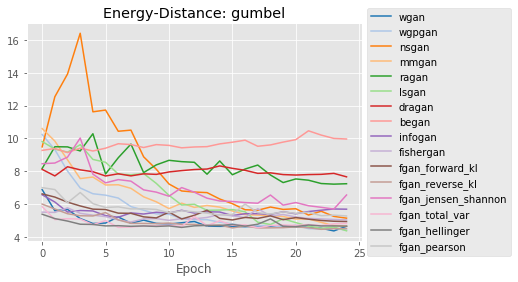

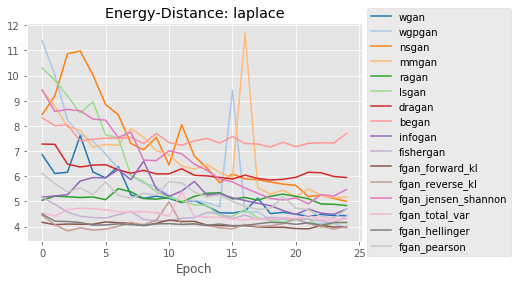

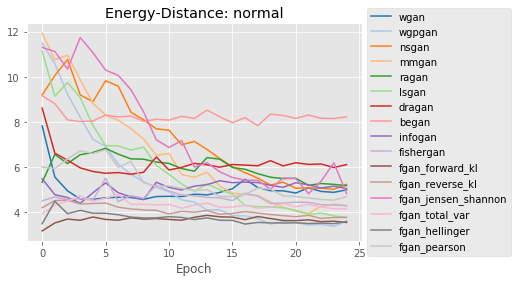

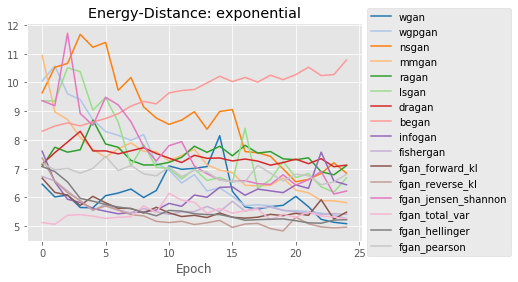

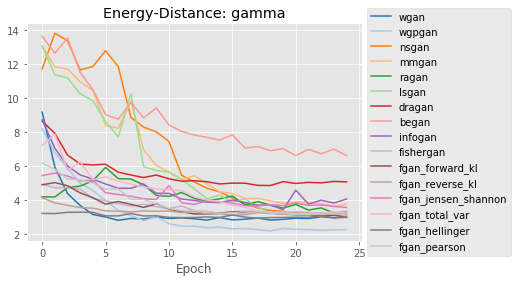

In [25]:
graph_multivariate(optimal_10000)

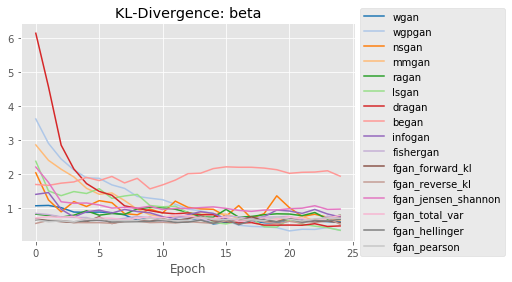

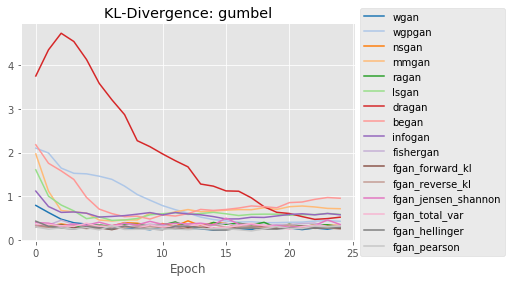

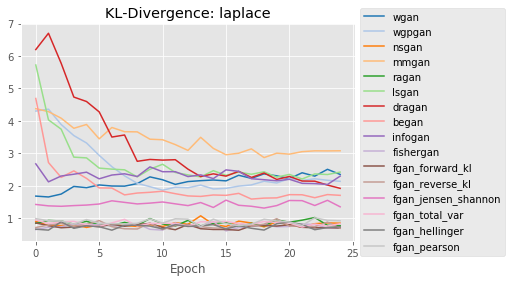

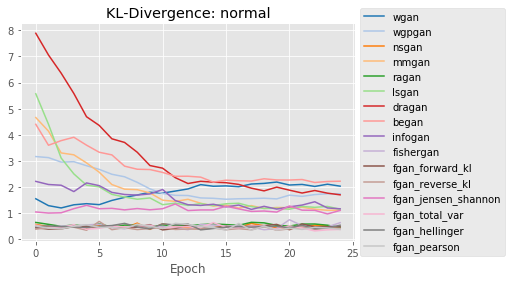

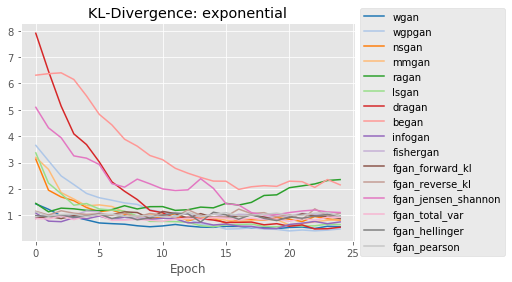

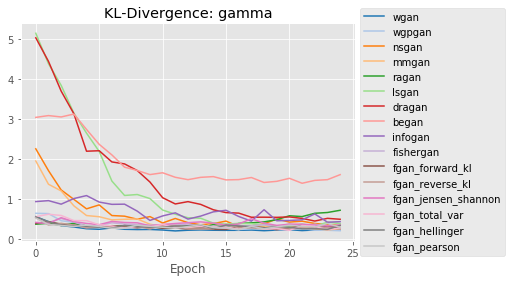

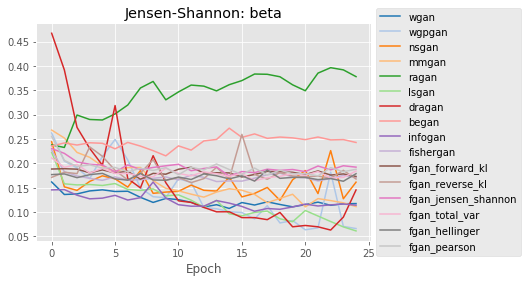

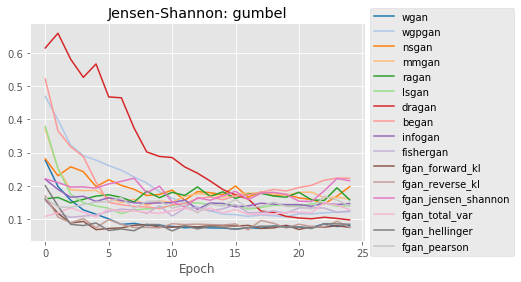

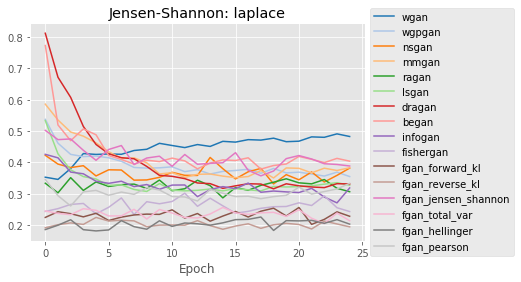

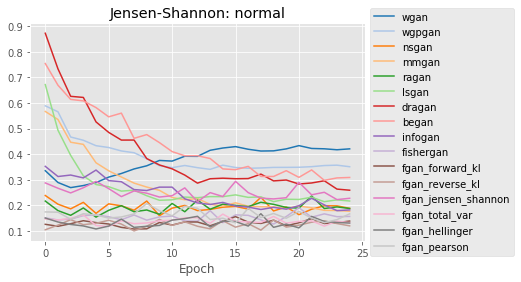

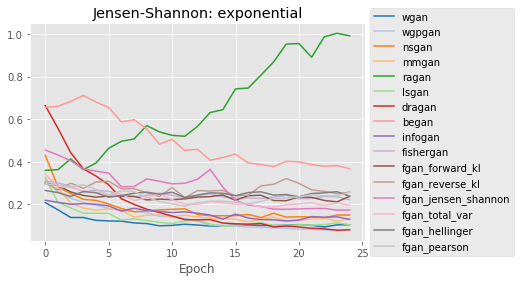

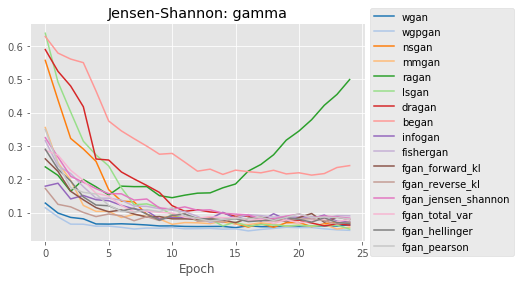

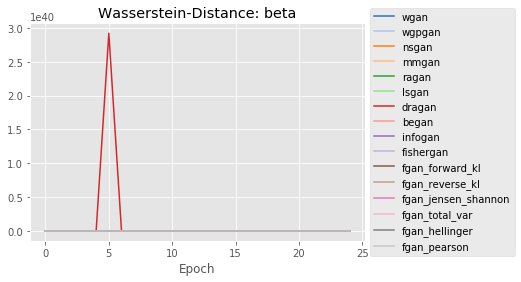

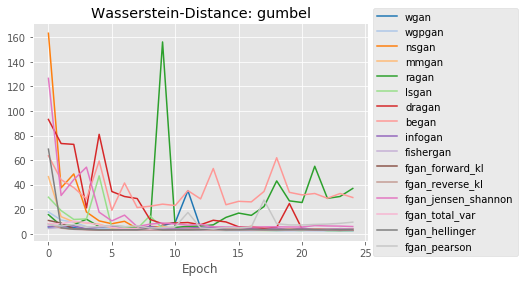

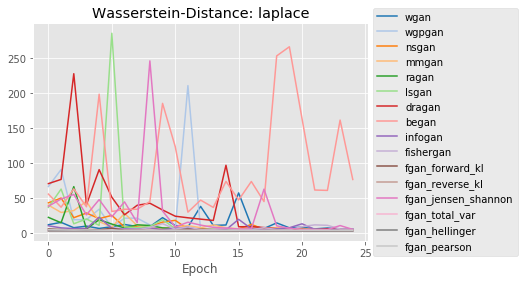

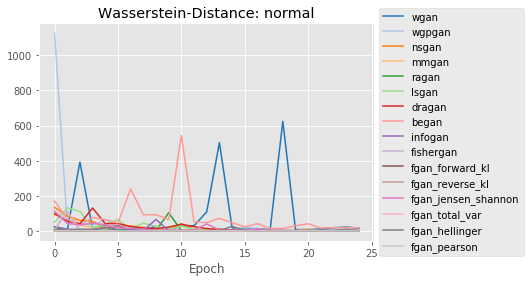

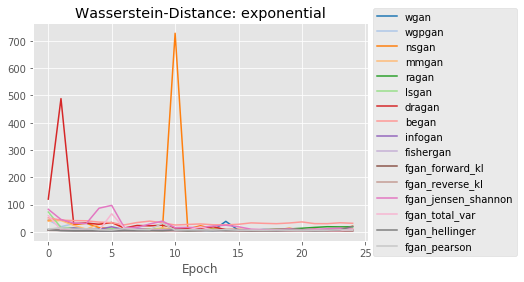

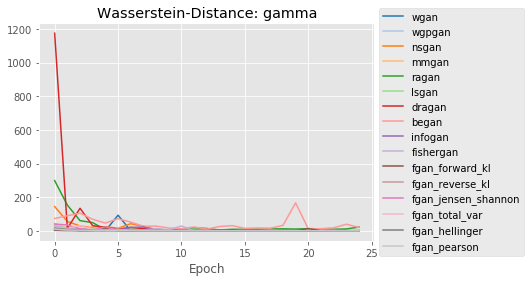

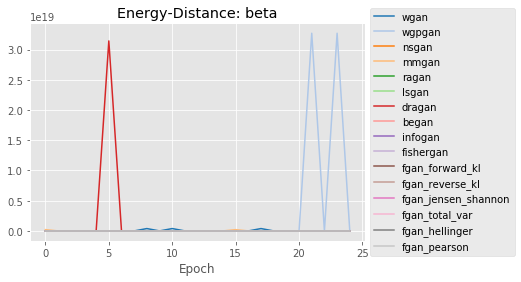

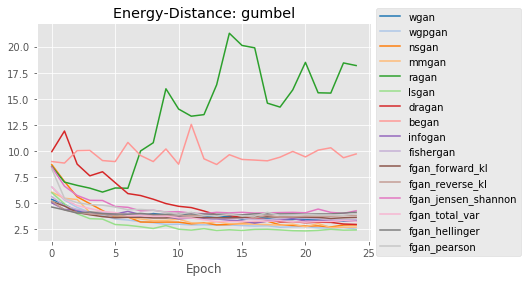

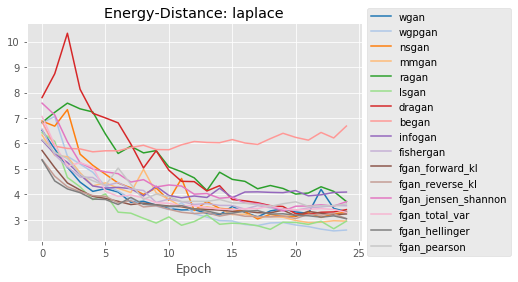

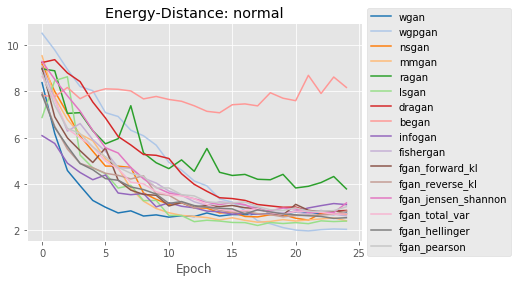

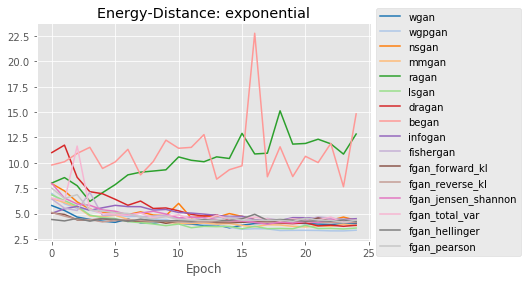

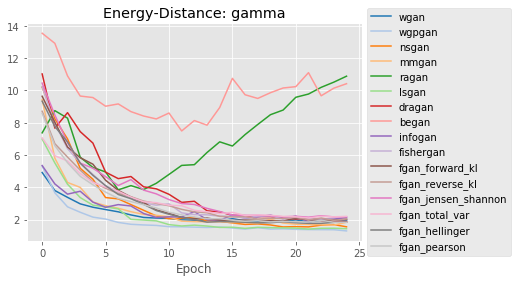

In [26]:
graph_multivariate(optimal_100000)

In [129]:
""" Print confidence intervals for minimum across all runs """
for metric in distance_metrics:
    
    print('\n======================')
    print('{0}'.format(metric))
    print('======================\n')
        
    for samples, optimal in [(1000, optimal_1000), (10000, optimal_10000), (100000, optimal_100000)]:
        
        param_dict = nested_pickle_dict()
        print('\n{0} Samples \n'.format(samples))

        for distribution in distributions:

            for model_name in model_names:
                
                minimums = np.min(np.array(optimal[model_name][distribution][metric]['values']), axis=1)
                mu, h, low, high = mean_confidence_interval(minimums)
                param_dict[model_name][distribution] = '%.3f ± %.3f' % (np.round(mu, 3), np.round(h, 3))
        
        data = [[key, param_dict[key]['normal'], param_dict[key]['beta'], param_dict[key]['gumbel'],
                      param_dict[key]['laplace'], param_dict[key]['exponential'], param_dict[key]['gamma']]
                 for key in model_names]
        print(tabulate(data, headers=['Model', 'Normal', 'Beta', 'Gumbel', 'Laplace', 'Exponential', 'Gamma']), '\n')
        
        rankings = np.argsort([[eval(i[:4]) if i[:4] != 'nan ' else 1e10 for i in j[1:]] for j in data], axis=0)
        for j in range(rankings.shape[1]):
            print(distributions[j].capitalize(), [(idx, model_names[name]) for idx, name in enumerate(rankings[:, j])], '\n')


KL-Divergence


1000 Samples 

Model                Normal         Beta           Gumbel         Laplace        Exponential    Gamma
-------------------  -------------  -------------  -------------  -------------  -------------  -------------
wgan                 0.253 ± 0.034  0.370 ± 0.027  0.144 ± 0.011  0.487 ± 0.034  0.345 ± 0.058  0.151 ± 0.015
wgpgan               0.663 ± 0.148  0.791 ± 0.048  0.480 ± 0.086  1.263 ± 0.195  0.670 ± 0.032  0.279 ± 0.048
nsgan                0.157 ± 0.015  nan ± nan      0.144 ± 0.007  0.414 ± 0.025  0.486 ± 0.073  0.168 ± 0.021
mmgan                1.823 ± 0.151  0.756 ± 0.069  0.584 ± 0.107  2.050 ± 0.217  0.750 ± 0.037  0.727 ± 0.068
ragan                0.210 ± 0.069  0.451 ± 0.082  0.153 ± 0.010  0.436 ± 0.036  0.522 ± 0.057  0.160 ± 0.026
lsgan                0.573 ± 0.132  0.693 ± 0.059  0.323 ± 0.038  0.811 ± 0.130  0.714 ± 0.035  0.543 ± 0.069
dragan               1.754 ± 0.093  0.720 ± 0.073  0.836 ± 0.081  1.973 ± 0.339  0.641 ± 0.047  

Model                Normal         Beta           Gumbel         Laplace        Exponential    Gamma
-------------------  -------------  -------------  -------------  -------------  -------------  -------------
wgan                 0.186 ± 0.023  0.083 ± 0.007  0.046 ± 0.004  0.264 ± 0.020  0.066 ± 0.006  0.035 ± 0.003
wgpgan               0.232 ± 0.016  0.048 ± 0.008  0.061 ± 0.004  0.297 ± 0.011  0.062 ± 0.004  0.031 ± 0.002
nsgan                0.072 ± 0.009  0.072 ± 0.008  0.062 ± 0.004  0.211 ± 0.011  0.083 ± 0.004  0.034 ± 0.002
mmgan                0.146 ± 0.015  0.076 ± 0.007  0.073 ± 0.005  0.262 ± 0.010  0.077 ± 0.004  0.036 ± 0.003
ragan                0.088 ± 0.007  0.160 ± 0.007  0.064 ± 0.006  0.215 ± 0.010  0.193 ± 0.012  0.054 ± 0.006
lsgan                0.175 ± 0.008  0.048 ± 0.011  0.073 ± 0.004  0.245 ± 0.009  0.063 ± 0.005  0.031 ± 0.002
dragan               0.200 ± 0.014  0.048 ± 0.012  0.068 ± 0.004  0.263 ± 0.013  0.064 ± 0.010  0.044 ± 0.005
began             

Gumbel [(0, 'wgan'), (1, 'fgan_reverse_kl'), (2, 'lsgan'), (3, 'infogan'), (4, 'wgpgan'), (5, 'fgan_hellinger'), (6, 'fgan_total_var'), (7, 'fgan_forward_kl'), (8, 'nsgan'), (9, 'fishergan'), (10, 'fgan_pearson'), (11, 'mmgan'), (12, 'fgan_jensen_shannon'), (13, 'ragan'), (14, 'dragan'), (15, 'began')] 

Laplace [(0, 'wgan'), (1, 'fgan_reverse_kl'), (2, 'lsgan'), (3, 'fgan_forward_kl'), (4, 'fgan_hellinger'), (5, 'wgpgan'), (6, 'fishergan'), (7, 'fgan_total_var'), (8, 'fgan_pearson'), (9, 'infogan'), (10, 'mmgan'), (11, 'nsgan'), (12, 'fgan_jensen_shannon'), (13, 'ragan'), (14, 'dragan'), (15, 'began')] 

Exponential [(0, 'wgan'), (1, 'fgan_reverse_kl'), (2, 'fgan_hellinger'), (3, 'fgan_total_var'), (4, 'fgan_forward_kl'), (5, 'fishergan'), (6, 'infogan'), (7, 'wgpgan'), (8, 'fgan_pearson'), (9, 'lsgan'), (10, 'mmgan'), (11, 'fgan_jensen_shannon'), (12, 'nsgan'), (13, 'ragan'), (14, 'dragan'), (15, 'began')] 

Gamma [(0, 'wgpgan'), (1, 'wgan'), (2, 'fgan_hellinger'), (3, 'nsgan'), (4, 

In [127]:
""" Print confidence intervals for minimum across all runs """
for metric in distance_metrics:
    
    print('\n======================')
    print('{0}'.format(metric))
    print('======================\n')
        
    for samples, optimal in [(1000, optimal_1000), (10000, optimal_10000), (100000, optimal_100000)]:
        
        param_dict = nested_pickle_dict()
        print('\n{0} Samples \n'.format(samples))

        for distribution in distributions:

            for model_name in model_names:
                
                minimums = np.min(np.array(optimal[model_name][distribution][metric]['values']), axis=1)
                mu, h, low, high = mean_confidence_interval(minimums)
                param_dict[model_name][distribution] = '%.3f ± %.3f' % (np.round(mu, 3), np.round(h, 3))
        
        data = [[key, param_dict[key]['normal'], param_dict[key]['beta'], param_dict[key]['gumbel'],
                      param_dict[key]['laplace'], param_dict[key]['exponential'], param_dict[key]['gamma']]
                 for key in model_names]
        print(tabulate(data, headers=['Model', 'Normal', 'Beta', 'Gumbel', 'Laplace', 'Exponential', 'Gamma']))


KL-Divergence


1000 Samples 

Model                Normal         Beta           Gumbel         Laplace        Exponential    Gamma
-------------------  -------------  -------------  -------------  -------------  -------------  -------------
wgan                 0.253 ± 0.034  0.370 ± 0.027  0.144 ± 0.011  0.487 ± 0.034  0.345 ± 0.058  0.151 ± 0.015
wgpgan               0.663 ± 0.148  0.791 ± 0.048  0.480 ± 0.086  1.263 ± 0.195  0.670 ± 0.032  0.279 ± 0.048
nsgan                0.157 ± 0.015  nan ± nan      0.144 ± 0.007  0.414 ± 0.025  0.486 ± 0.073  0.168 ± 0.021
mmgan                1.823 ± 0.151  0.756 ± 0.069  0.584 ± 0.107  2.050 ± 0.217  0.750 ± 0.037  0.727 ± 0.068
ragan                0.210 ± 0.069  0.451 ± 0.082  0.153 ± 0.010  0.436 ± 0.036  0.522 ± 0.057  0.160 ± 0.026
lsgan                0.573 ± 0.132  0.693 ± 0.059  0.323 ± 0.038  0.811 ± 0.130  0.714 ± 0.035  0.543 ± 0.069
dragan               1.754 ± 0.093  0.720 ± 0.073  0.836 ± 0.081  1.973 ± 0.339  0.641 ± 0.047  

Model                Normal          Beta           Gumbel          Laplace         Exponential     Gamma
-------------------  --------------  -------------  --------------  --------------  --------------  --------------
wgan                 1.055 ± 0.129   5.154 ± 0.193  2.060 ± 0.233   3.197 ± 0.318   3.183 ± 0.314   0.830 ± 0.074
wgpgan               2.738 ± 0.303   6.955 ± 0.409  4.058 ± 0.573   5.022 ± 0.581   6.439 ± 0.626   1.468 ± 0.293
nsgan                1.118 ± 0.169   7.576 ± 0.279  3.049 ± 0.311   3.156 ± 0.257   4.414 ± 0.415   1.341 ± 0.172
mmgan                6.369 ± 0.791   8.407 ± 0.299  6.876 ± 0.764   7.920 ± 0.481   8.352 ± 0.853   7.020 ± 0.386
ragan                1.564 ± 0.285   7.460 ± 0.414  2.938 ± 0.497   3.488 ± 0.322   4.688 ± 0.500   1.255 ± 0.209
lsgan                2.988 ± 0.401   7.791 ± 0.347  4.145 ± 0.514   4.722 ± 0.442   5.343 ± 0.445   4.530 ± 0.511
dragan               5.183 ± 0.466   nan ± nan      7.603 ± 0.562   6.499 ± 0.875   8.573 ± 0.6

In [28]:
""" Get number of different hyperparameters for each minimum run """
from tabulate import tabulate

for samples, optimal in [(1000, optimal_1000), (10000, optimal_10000), (100000, optimal_100000)]:
    
    print('\n======================')
    print('{0} Samples'.format(samples))
    print('======================\n')
    
    for metric in distance_metrics:
        
        param_dict = nested_pickle_dict()
        print('\n{0} \n'.format(metric))

        for distribution in distributions:

            for model_name in optimal.keys():
                param_dict[model_name][distribution] = len(set([tuple(t) for t in optimal[model_name][distribution][metric]['parameters']]))

        print(tabulate([[key, param_dict[key]['normal'], param_dict[key]['beta'], param_dict[key]['gumbel'],
                              param_dict[key]['laplace'], param_dict[key]['exponential'], param_dict[key]['gamma']]
                         for key in param_dict.keys()],
                        headers=['Model', 'Normal', 'Beta', 'Gumbel', 'Laplace', 'Exponential', 'Gamma']))


1000 Samples


KL-Divergence 

Model                  Normal    Beta    Gumbel    Laplace    Exponential    Gamma
-------------------  --------  ------  --------  ---------  -------------  -------
mmgan                      12       7         9         12              8       11
fgan_jensen_shannon        13      11         6         12             14       11
nsgan                       6       8         7          7              6        9
fgan_reverse_kl            12      11         8          8              6       11
fgan_hellinger             10       8         9         10              8       11
dragan                     17      12        17         11             15       14
ragan                       9       9         8          9              8       11
fgan_forward_kl             9       9         9         10              8       12
wgpgan                      9      10        10          5             12       15
fgan_total_var             10       9         8        